# 「国土数値情報・将来推計人口メッシュ」のデータ変換

国土交通省の[国土数値情報　ダウンロードサービス](http://nlftp.mlit.go.jp/ksj/index.html)で公開されている[国土数値情報　500mメッシュ別将来推計人口（H29国政局推計）](http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-mesh500.html)のデータは Shape 形式 （文字エンコードは *Shift-JIS*） ですので、GeoJSON 形式に変換します。
変換には PostGIS を使います。

PostGIS 環境は Docker で用意します。
Docker のイメージは [mdillon/postgis](https://hub.docker.com/r/mdillon/postgis/) を使います。
PostgreSQL のバージョンは 10.3、PostGIS のバージョンは 2.4 です。
事前に Docker を利用できるようにしておいてください。Jupyter を実行しているユーザーを *docker* グループに追加しておくと良いでしょう。

ノートブック内で Python から PostgreSQL にアクセスするには [Psycopg](http://initd.org/psycopg/) を使います。

## 環境の用意

イメージをダウンロードしてコンテナを起動します。コンテナ名は `postgis` とします。デーモンとして起動しておきますので *-d* オプションを付けます。また、Python からアクセスできるように 5432 番ポートをホスト側に公開します。

In [1]:
!docker run --name postgis -d -p 5432:5432 mdillon/postgis:10

10ca5c90f86a9b325b0d04706de2ce317be874e97f891ba6f05028941a75aaf2


Python の PostgreSQL ライブラリである *psycopg2* をインストールします。

In [2]:
!pip install psycopg2-binary

デーモンとして起動したコンテナに接続し、PostGIS や各種ライブラリのバージョンを確認します。
`version()` と `postgis_full_version()` 関数で確認できます。

In [3]:
import pprint
import psycopg2
conn = psycopg2.connect("host=127.0.0.1 user=postgres")
cur = conn.cursor()
cur.execute('SELECT version(), postgis_full_version()')
pprint.pprint(cur.fetchone())

('PostgreSQL 10.3 (Debian 10.3-1.pgdg90+1) on x86_64-pc-linux-gnu, compiled by '
 'gcc (Debian 6.3.0-18+deb9u1) 6.3.0 20170516, 64-bit',
 'POSTGIS="2.4.3 r16312" PGSQL="100" GEOS="3.5.1-CAPI-1.9.1 r4246" PROJ="Rel. '
 '4.9.3, 15 August 2016" GDAL="GDAL 2.1.2, released 2016/10/24" LIBXML="2.9.4" '
 'LIBJSON="0.12.1" LIBPROTOBUF="1.2.1" TOPOLOGY RASTER')


## データの用意

「国土数値情報　500mメッシュ別将来推計人口（H29国政局推計）」を利用します。
サイトで地域を選択し、利用条件を読んで利用用途のアンケートに記入してからファイルをダウンロードします。

| 項目 | 内容 |
|------|------|
| ファイル名  | `m500-17_GML.zip` |
| ファイル容量 | 108.58MB |
| 年度 | 平成29年 |
| 測地系 | 世界測地系 |
| 地域 | 全国 |

ZIP ファイルには Shape ファイルが含まれますので、拡張子が ".shp" のものと、その他に ".dbf" などいくつかのファイルがあります。
ZIP ファイルは */tmp* フォルダに置いてあるものとします。
展開したファイルを合計すると760MB程度になります。

In [4]:
import zipfile
with zipfile.ZipFile('/tmp/m500-17_GML.zip') as myzip:
    print(myzip.namelist())
    myzip.extractall()

['Mesh4_POP_00.dbf', 'Mesh4_POP_00.prj', 'Mesh4_POP_00.shp', 'Mesh4_POP_00.shx']


## データの変換

PostGIS パッケージに含まれる `shp2pgsql` を使って Shape ファイルを PostGIS 向けの SQL に変換します。
SQL でのテーブル名は `mesh4_pop_00` になります。
テーブル名を指定するには `shp2pgsql` の第二引数に与えます。

In [5]:
!docker run --rm -v `pwd`:/tmp mdillon/postgis:10 \
        shp2pgsql -W Shift_JIS /tmp/Mesh4_POP_00.shp 2>/dev/null | gzip > /tmp/mesh4_pop_00.sql.gz

SQLを実行します。Shape ファイルからの変換結果は膨大な SQL 文になりますので、個別にクエリを実行するように調整します。
カーソル変数 *cur* は上で定義済みとします。

In [6]:
import gzip
import io

buffer = io.StringIO()
with gzip.open('/tmp/mesh4_pop_00.sql.gz', 'rt') as fp:
    for line in fp:
        s = str(line).strip()
        buffer.write(s)
        if s.endswith(';'):
            cur.execute(buffer.getvalue())
            buffer = io.StringIO()

テーブルに登録されたデータ件数などを集計します。

In [7]:
cur.execute('''
SELECT COUNT(*),
       COUNT(DISTINCT mesh_id), MIN(LENGTH(mesh_id::VARCHAR)), MAX(LENGTH(mesh_id::VARCHAR)),
       COUNT(DISTINCT SUBSTR(LPAD(mesh_id::VARCHAR, 9, '0'), 1, 4)),
       COUNT(DISTINCT city_code), MIN(LENGTH(city_code::VARCHAR)), MAX(LENGTH(city_code::VARCHAR)),
       COUNT(DISTINCT SUBSTR(LPAD(city_code::VARCHAR, 5, '0'), 1, 2)),
       SUM(pop2010), SUM(pop2020), SUM(pop2025), SUM(pop2030),
       SUM(pop2035), SUM(pop2040), SUM(pop2045), SUM(pop2050)
  FROM mesh4_pop_00''')
cur.fetchone()

(477172,
 477172,
 9,
 9,
 151,
 1901,
 4,
 5,
 47,
 Decimal('128057299.4500000000'),
 Decimal('124099899.6100000000'),
 Decimal('120658794.2300000000'),
 Decimal('116617639.1000000000'),
 Decimal('112123552.9600000000'),
 Decimal('107275835.9800000000'),
 Decimal('102210424.5700000000'),
 Decimal('97074839.9400000000'))

レコード数は 477,172 件、メッシュIDの上位４桁の一次メッシュは151種類、住所コードの上位２桁の都道府県コードは47種類あることを確認できます。Shapeファイルからの変換時に住所コードは数値として処理されているため、先頭のゼロが欠落して4桁になっている場合も見受けられます。また、人口は2010年以降は減少していく推計であることも確認できます。

## データの確認

データ内容については、国土数値情報のダウンロードページで確認してください。
POP が人口、INDEX が人口数の指数です。
最初と最後のカラムの *gid* と *geom* は `shp2pgsql` が付加したデータです。

In [8]:
columns = ['gid', 'mesh_id', 'city_code']
for p in ('', 'a', 'b', 'c', 'd'):
    columns.append('pop2010{}'.format(p))
    columns.extend(['pop{}{}'.format(y, p) for y in range(2020, 2051, 5)])
    columns.extend(['index{}{}'.format(y, p) for y in range(2020, 2051, 5)])
columns.append('geom')
print('{} columns'.format(len(columns)))

79 columns


In [9]:
cur.execute("SELECT * FROM mesh4_pop_00 LIMIT 1")
r = cur.fetchone()
print(len(r))
dict(zip(columns, r))

79


{'gid': 1,
 'mesh_id': 654560984,
 'city_code': 1694,
 'pop2010': Decimal('3.3600000000'),
 'pop2020': Decimal('2.0700000000'),
 'pop2025': Decimal('1.7900000000'),
 'pop2030': Decimal('1.5800000000'),
 'pop2035': Decimal('0E-10'),
 'pop2040': Decimal('0E-10'),
 'pop2045': Decimal('0E-10'),
 'pop2050': Decimal('0E-10'),
 'index2020': Decimal('61.6070000000'),
 'index2025': Decimal('53.2740000000'),
 'index2030': Decimal('47.0240000000'),
 'index2035': Decimal('0E-10'),
 'index2040': Decimal('0E-10'),
 'index2045': Decimal('0E-10'),
 'index2050': Decimal('0E-10'),
 'pop2010a': Decimal('0E-10'),
 'pop2020a': Decimal('0.0900000000'),
 'pop2025a': Decimal('0.1300000000'),
 'pop2030a': Decimal('0.1300000000'),
 'pop2035a': Decimal('0E-10'),
 'pop2040a': Decimal('0E-10'),
 'pop2045a': Decimal('0E-10'),
 'pop2050a': Decimal('0E-10'),
 'index2020a': Decimal('-10.0000000000'),
 'index2025a': Decimal('-10.0000000000'),
 'index2030a': Decimal('-10.0000000000'),
 'index2035a': Decimal('-10.0000000

都道府県コードごとのデータ件数と人口を確認します。
クエリ結果に合わせたカラム名と組み合わせて *pandas* の DataFrame にまとめます。

In [10]:
import pandas as pd

cur.execute('''
SELECT substr(lpad(city_code::varchar, 5, '0'), 1, 2) AS prefcode,
       COUNT(*) AS cnt,
       sum(pop2010) AS pop2010,
       sum(pop2020) AS pop2020,
       sum(pop2025) AS pop2025,
       sum(pop2030) AS pop2030,
       sum(pop2035) AS pop2035,
       sum(pop2040) AS pop2040,
       sum(pop2045) AS pop2045,
       sum(pop2050) AS pop2050
  FROM mesh4_pop_00
GROUP BY 1 ORDER BY 1
''')

cols = ['pref', 'cnt', 'pop2010']
cols.extend(['pop{}'.format(y) for y in range(2020, 2051, 5)])
df = pd.DataFrame(cur.fetchall(), columns=cols)
df

,pref,cnt,pop2010,pop2020,pop2025,pop2030,pop2035,pop2040,pop2045,pop2050
0,01,45488,5506417.9100000000,5178050.6700000000,4959981.8700000000,4719097.5800000000,4462040.7300000000,4190071.9900000000,3909213.2100000000,3635557.1800000000
1,02,8484,1373338.8000000000,1236177.8800000000,1161430.5600000000,1085118.2200000000,1008723.7300000000,932028.3300000000,854415.9600000000,779108.3400000000
2,03,17185,1330147.6400000000,1206440.6100000000,1139824.3800000000,1072338.9600000000,1005328.6100000000,938103.2700000000,869574.7200000000,803175.5900000000
3,04,13221,2348165.0200000000,2269041.0700000000,2210120.6500000000,2140709.6500000000,2061970.2100000000,1972576.4400000000,1874827.6000000000,1775509.7600000000
4,05,9872,1085997.0700000000,959272.1400000000,893223.3500000000,827461.6900000000,763356.2000000000,699814.0100000000,636492.6300000000,576554.1400000000
5,06,7993,1168923.9100000000,1062187.9600000000,1005849.4100000000,949291.8000000000,892933.5700000000,835553.7400000000,776728.9500000000,719623.2700000000
6,07,18917,2029064.4000000000,1873536.9900000000,1780164.3400000000,1684357.1500000000,1586584.0000000000,1485157.8600000000,1380105.5200000000,1277604.3700000000
7,08,16541,2969769.7000000000,2852546.5200000000,2764114.5200000000,2661093.0900000000,2546158.1000000000,2422742.9100000000,2293655.7900000000,2165058.0700000000
8,09,12753,2007683.8600000000,1926236.6900000000,1867192.2200000000,1799781.4200000000,1724934.6500000000,1643367.2900000000,1556890.4800000000,1470092.7200000000
9,10,8891,2008067.8900000000,1920493.4700000000,1857906.8100000000,1787482.5400000000,1710958.0400000000,1629974.0900000000,1546412.8400000000,1463057.1300000000


グラフを描画してデータを確認します。

In [11]:
%matplotlib inline

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

都道府県ごとのレコード数をグラフに描画します。

<BarContainer object of 47 artists>

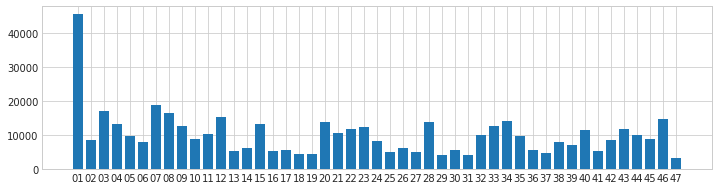

In [13]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 1, 1)
ax.bar(df.pref, df.cnt)

都道府県コードごとの人口をグラフに描画します。
`subplots` で8行分の領域を作成し、それぞれに2010年の人口と2020年以降の推計人口を表示します。

<BarContainer object of 47 artists>

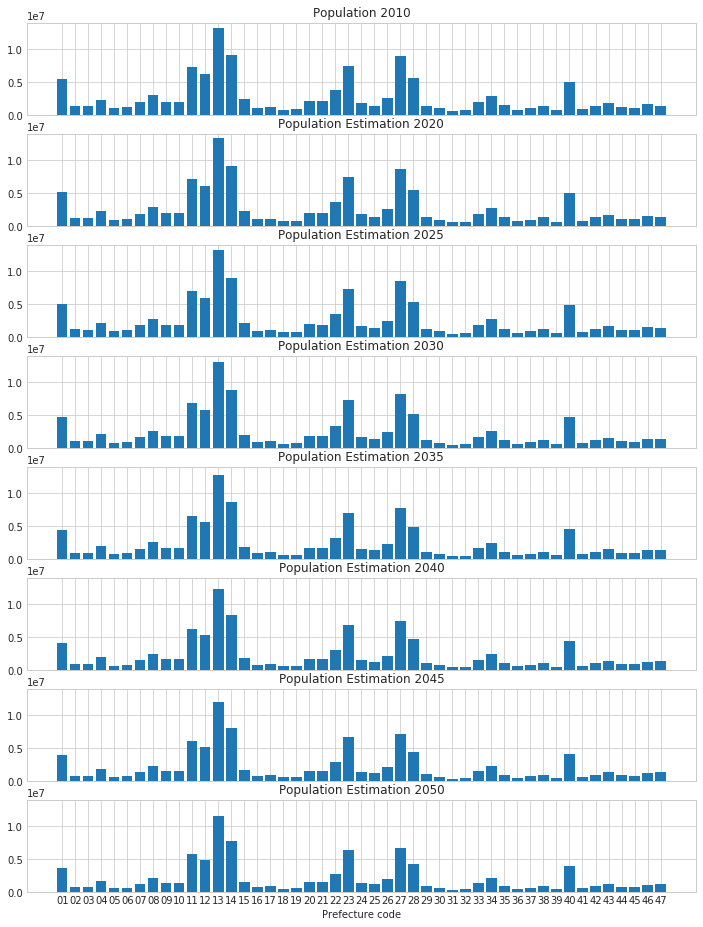

In [14]:
fig, ax = plt.subplots(8, 1, figsize=(12, 16), sharex=True, sharey=True)
ax[0].set_title('Population 2010')
ax[1].set_title('Population Estimation 2020')
ax[2].set_title('Population Estimation 2025')
ax[3].set_title('Population Estimation 2030')
ax[4].set_title('Population Estimation 2035')
ax[5].set_title('Population Estimation 2040')
ax[6].set_title('Population Estimation 2045')
ax[7].set_title('Population Estimation 2050')
ax[7].set_xlabel('Prefecture code')
ax[0].bar(df.pref, df.pop2010)
ax[1].bar(df.pref, df.pop2020)
ax[2].bar(df.pref, df.pop2025)
ax[3].bar(df.pref, df.pop2030)
ax[4].bar(df.pref, df.pop2035)
ax[5].bar(df.pref, df.pop2040)
ax[6].bar(df.pref, df.pop2045)
ax[7].bar(df.pref, df.pop2050)

## データの出力

2種類の GeoJSON 形式と、形状データ無しのCSVファイルを出力します。

データを変換する SQL を定義し、都道府県コードをパラメータで渡します。
47都道府県に対して FOR ループを回してそれぞれのファイルをディスクに保存します。

In [15]:
import json

sql = """
SELECT row_to_json(featurecollection)
FROM (
  SELECT
    'FeatureCollection' AS type,
    array_to_json(array_agg(feature)) AS features
  FROM (
    SELECT
      'Feature' AS type,
      ST_AsGeoJSON(geom)::json AS geometry,
      row_to_json((
        SELECT p FROM (
          SELECT
            pop2010 AS population,
            pop2020 AS pop2020,
            pop2025 AS pop2025,
            pop2030 AS pop2030,
            pop2035 AS pop2035,
            pop2040 AS pop2040,
            pop2045 AS pop2045,
            pop2050 AS pop2050,
            mesh_id::varchar AS mesh,
            lpad(city_code::varchar, 5, '0') AS city_code
          ) AS p
      )) AS properties
    FROM mesh4_pop_00
    WHERE substr(lpad(city_code::varchar, 5, '0'), 1, 2) = %s
  ) AS feature
) AS featurecollection
"""

for p in range(47):
    pref = '{:02d}'.format(p+1)
    cur.execute(sql, (pref,))
    geo = cur.fetchone()
    with open('pref-{}-population.geojson'.format(pref), 'w') as fp:
        json.dump(geo[0], fp)

GeoJSON ファイルを ZIP ファイルにまとめます。

In [16]:
import zipfile
with zipfile.ZipFile('/tmp/prefecture-population-geojson.zip', 'w') as myzip:
    for p in range(47):
        pref = '{:02d}'.format(p+1)
        myzip.write('pref-{}-population.geojson'.format(pref))

テーブルの行ごとに GeoJSON の Feature に変換してから一次メッシュコードごとにデータを集約する SQL を定義して実行します。一次メッシュコードごとの GeoJSON ファイルをディスクに保存します。

In [17]:
import json

sql = """
SELECT mesh1,
       row_to_json((SELECT c FROM (SELECT
         'FeatureCollection' AS type,
         features
       ) AS c)) AS featurecollection
FROM (
  SELECT
    mesh1,
    array_agg(feature) AS features
  FROM (
    SELECT
      substr(lpad(mesh_id::VARCHAR, 9, '0'), 1, 4) AS mesh1,
      row_to_json((SELECT f FROM (SELECT
        'Feature' AS type,
        ST_AsGeoJSON(geom)::JSON AS geometry,
        row_to_json((SELECT p FROM (SELECT
          pop2010 AS population,
          pop2020 AS pop2020,
          pop2025 AS pop2025,
          pop2030 AS pop2030,
          pop2035 AS pop2035,
          pop2040 AS pop2040,
          pop2045 AS pop2045,
          pop2050 AS pop2050,
          mesh_id::VARCHAR AS mesh,
          lpad(city_code::VARCHAR, 5, '0') AS city_code
        ) AS p)) AS properties
      ) AS f)) AS feature
    FROM mesh4_pop_00
  ) AS t1
  GROUP BY mesh1
) AS t2
ORDER BY mesh1
"""

cur.execute(sql)
for record in cur:
    with open('mesh1-{}-population.geojson'.format(record[0]), 'w') as fp:
        json.dump(record[1], fp)

GeoJSON ファイルを ZIP ファイルにまとめます。

In [18]:
import glob
import zipfile

with zipfile.ZipFile('/tmp/mesh1-population-geojson.zip', 'w') as myzip:
    for f in glob.glob('mesh1-*-population.geojson'):
        myzip.write(f)

形状データ無しのCSVファイルを出力します。

In [19]:
import csv

q = 'SELECT {} FROM mesh4_pop_00 ORDER BY 1'.format(','.join(columns[:-1]))
cur.execute(q)

with open('/tmp/mesh4-population.csv', 'w') as fp:
    writer = csv.writer(fp, quoting=csv.QUOTE_ALL)
    writer.writerow(columns[:-1])
    for record in cur:
        # Format each cell as string
        r = [record[0], record[1]]  # gid, mesh_id
        r.append('{:05d}'.format(record[2]))  # city_code
        for v in record[3:]:
            r.append('{:.02f}'.format(v))
        writer.writerow(r)

## まとめ

国土交通省の国土数値情報ダウンロードサービスで公開されている　「国土数値情報　500mメッシュ別将来推計人口（H29国政局推計）」のShapeファイルを GeoJSON 形式と CSV 形式（形状データ無し）に変換しました。

- `prefecture-population-geojson.zip` (191MB)
- `mesh1-population-geojson.zip` (191MB)
- `mesh4-population.csv` (286MB)